In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn import metrics

Notes

-> Currently, the daily maximum dataframe is done station-wise. So for each day, there are ~20 dmax gusts. This creates potential double-counting of SCW events and non-events. Consider just keeping the domain-max gust


Number of SCW events:  218
Number of DJF events before Dec 2015:  60


/jobfs/71298917.gadi-pbs/ipykernel_161756/1948878748.py:18: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  min_corr = df[["month","stn_id","gust","wg10_barra_12km_point","wg10_12km_point","wg10_2p2_point"]].\
/jobfs/71298917.gadi-pbs/ipykernel_161756/1948878748.py:20: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  max_corr = df[["month","stn_id","gust","wg10_barra_12km_point","wg10_12km_point","wg10_2p2_point"]].\


SCW prediction...

wg10_12km_point
AUC = 0.6531553706121265 

wg10_barra_12km_point
AUC = 0.671857321583986 

wg10_2p2_point
AUC = 0.8228223817812591 

wg10_12km_rad
AUC = 0.6900210630016439 

wg10_barra_12km_rad
AUC = 0.6963792488637464 

wg10_2p2_rad
AUC = 0.8435015955903684 

ebwd
AUC = 0.8641735567159851 

mucape*s06
AUC = 0.8830456435547819 



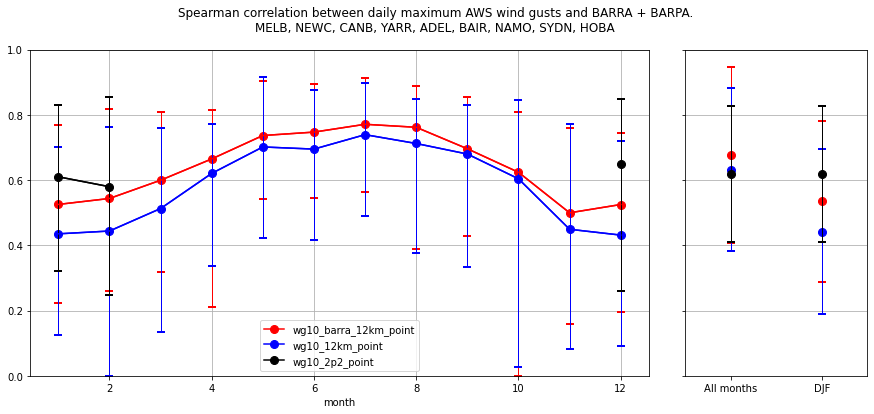

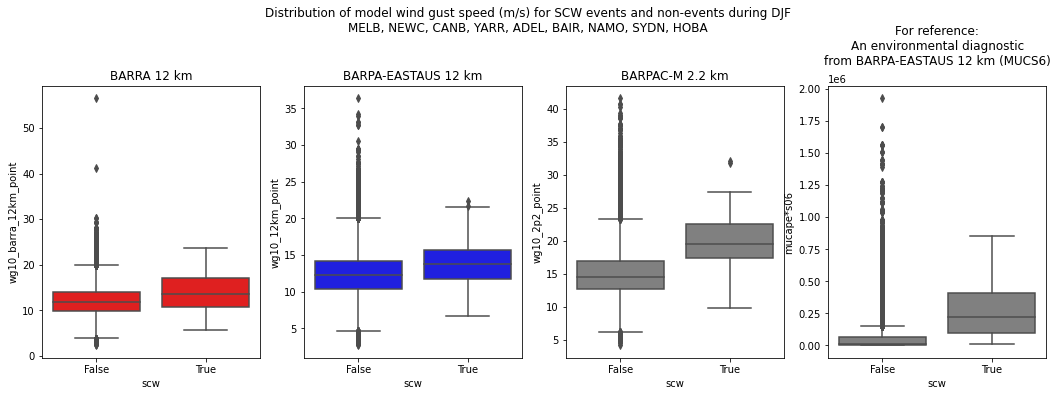

In [7]:
df = pd.DataFrame()
for rid in ["2","4","40","49","64","68","69","71","76"]:
    temp = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpa_barra_aws_"+rid+".csv")    
    temp["rid"] = rid    
    df=pd.concat([df, temp],axis=0)
df["month"] = pd.to_datetime(df["time"]).dt.month
#df = df.sort_values(["scw","gust"]).drop_duplicates(["time","rid"],keep="last")
print("Number of SCW events: ",df.scw.sum())
print("Number of DJF events before Dec 2015: ",df[(np.in1d(df.month,[12,1,2])) & (pd.to_datetime(df["time"]) < dt.datetime(2015,12,1))]["scw"].sum())

plt.figure(figsize=[15,6])

#Correlation time series
ax=plt.subplot2grid((1,4),(0,0),colspan=3)
corr = df[["month","gust","wg10_barra_12km_point","wg10_12km_point","wg10_2p2_point"]].\
groupby("month").corr(method="spearman").xs("gust", level=1).drop(columns="gust")
corr.plot(marker="o",ax=ax,color=["r","b","k"],legend=False,ms=8)
min_corr = df[["month","stn_id","gust","wg10_barra_12km_point","wg10_12km_point","wg10_2p2_point"]].\
    groupby(["month","stn_id"]).corr(method="spearman").xs("gust", level=2).min(level=0).drop(columns="gust")
max_corr = df[["month","stn_id","gust","wg10_barra_12km_point","wg10_12km_point","wg10_2p2_point"]].\
    groupby(["month","stn_id"]).corr(method="spearman").xs("gust", level=2).max(level=0).drop(columns="gust")

ax.grid()
ax.set_ylim([0,1])
plt.legend()

colors = ["red","blue","k"]
cnt=0
for col in ["wg10_barra_12km_point","wg10_12km_point","wg10_2p2_point"]:
    plt.errorbar(min_corr.index,corr[col],yerr=np.abs((pd.concat([min_corr[col],max_corr[col]],axis=1)).T.values - corr[col].values),
                 color=colors[cnt],capsize=4,capthick=2,elinewidth=1)
    cnt=cnt+1

plt.suptitle("Spearman correlation between daily maximum AWS wind gusts and BARRA + BARPA.\nMELB, NEWC, CANB, YARR, ADEL, BAIR, NAMO, SYDN, HOBA")


#Total correlations over
ax=plt.subplot2grid((1,4),(0,3),colspan=1)

#All months
corr_total = df[["gust","wg10_barra_12km_point","wg10_12km_point","wg10_2p2_point"]].corr(method="spearman")["gust"].drop("gust")
min_corr = df[["stn_id","gust","wg10_barra_12km_point","wg10_12km_point","wg10_2p2_point"]].\
    groupby(["stn_id"]).corr(method="spearman").xs("gust", level=1).min(axis=0).drop("gust")
max_corr = df[["stn_id","gust","wg10_barra_12km_point","wg10_12km_point","wg10_2p2_point"]].\
    groupby(["stn_id"]).corr(method="spearman").xs("gust", level=1).max(axis=0).drop("gust")

ax.plot(0,corr_total["wg10_barra_12km_point"],marker="o",color="r",ms=8)
ax.plot(0,corr_total["wg10_12km_point"],marker="o",color="b",ms=8)
ax.plot(0,corr_total["wg10_2p2_point"],marker="o",color="k",ms=8)
ax.errorbar(0,corr_total["wg10_barra_12km_point"],corr_total["wg10_barra_12km_point"]-min_corr["wg10_barra_12km_point"],
            color="r",capsize=4,capthick=2,elinewidth=1)
ax.errorbar(0,corr_total["wg10_12km_point"],corr_total["wg10_12km_point"]-min_corr["wg10_12km_point"],
            color="b",capsize=4,capthick=2,elinewidth=1)
ax.errorbar(0,corr_total["wg10_2p2_point"],corr_total["wg10_2p2_point"]-min_corr["wg10_2p2_point"],
            color="k",capsize=4,capthick=2,elinewidth=1)

#Summer months
corr_total = df[np.in1d(df.month,[12,1,2])][["gust","wg10_barra_12km_point","wg10_12km_point","wg10_2p2_point"]].corr(method="spearman")["gust"].drop("gust")
min_corr = df[np.in1d(df.month,[12,1,2])][["stn_id","gust","wg10_barra_12km_point","wg10_12km_point","wg10_2p2_point"]].\
    groupby(["stn_id"]).corr(method="spearman").xs("gust", level=1).min(axis=0).drop("gust")
max_corr = df[np.in1d(df.month,[12,1,2])][["stn_id","gust","wg10_barra_12km_point","wg10_12km_point","wg10_2p2_point"]].\
    groupby(["stn_id"]).corr(method="spearman").xs("gust", level=1).max(axis=0).drop("gust")

ax.plot(1,corr_total["wg10_barra_12km_point"],marker="o",color="r",ms=8)
ax.plot(1,corr_total["wg10_12km_point"],marker="o",color="b",ms=8)
ax.plot(1,corr_total["wg10_2p2_point"],marker="o",color="k",ms=8)
ax.errorbar(1,corr_total["wg10_barra_12km_point"],corr_total["wg10_barra_12km_point"]-min_corr["wg10_barra_12km_point"],
            color="r",capsize=4,capthick=2,elinewidth=1)
ax.errorbar(1,corr_total["wg10_12km_point"],corr_total["wg10_12km_point"]-min_corr["wg10_12km_point"],
            color="b",capsize=4,capthick=2,elinewidth=1)
ax.errorbar(1,corr_total["wg10_2p2_point"],corr_total["wg10_2p2_point"]-min_corr["wg10_2p2_point"],
            color="k",capsize=4,capthick=2,elinewidth=1)

ax.grid(axis="y")
ax.set_ylim([0,1])
ax.set_xlim([-0.5,1.5])
ax.set_xticks([0,1],["All months","DJF"])
ax.set_yticklabels("");

plt.figure(figsize=[18,5])
plt.subplot(1,4,1)
sns.boxplot(data=df[np.in1d(df.month,[12,1,2])],x="scw",y="wg10_barra_12km_point",color="r")
plt.title("BARRA 12 km")

plt.subplot(1,4,2)
sns.boxplot(data=df[np.in1d(df.month,[12,1,2])],x="scw",y="wg10_12km_point",color="b")
plt.title("BARPA-EASTAUS 12 km")

plt.subplot(1,4,3)
sns.boxplot(data=df[np.in1d(df.month,[12,1,2])],x="scw",y="wg10_2p2_point",color="grey")
plt.title("BARPAC-M 2.2 km")

plt.subplot(1,4,4)
sns.boxplot(data=df[np.in1d(df.month,[12,1,2])],x="scw",y="mucape*s06",color="grey")
plt.title("For reference:\nAn environmental diagnostic\nfrom BARPA-EASTAUS 12 km (MUCS6)\n")

plt.suptitle("Distribution of model wind gust speed (m/s) for SCW events and non-events during DJF\nMELB, NEWC, CANB, YARR, ADEL, BAIR, NAMO, SYDN, HOBA",y=1.1);

print("SCW prediction...\n")
for v in ["wg10_12km_point","wg10_barra_12km_point","wg10_2p2_point",
          "wg10_12km_rad","wg10_barra_12km_rad","wg10_2p2_rad",
          "ebwd","mucape*s06"]:
    print(v)
    print("AUC =",metrics.roc_auc_score((df[(np.in1d(df.month,[12,1,2])) & (pd.to_datetime(df["time"]) < dt.datetime(2015,12,1))]["scw"] * 1).values,
                  (df[(np.in1d(df.month,[12,1,2])) & (pd.to_datetime(df["time"]) < dt.datetime(2015,12,1))][v]).values), "\n")

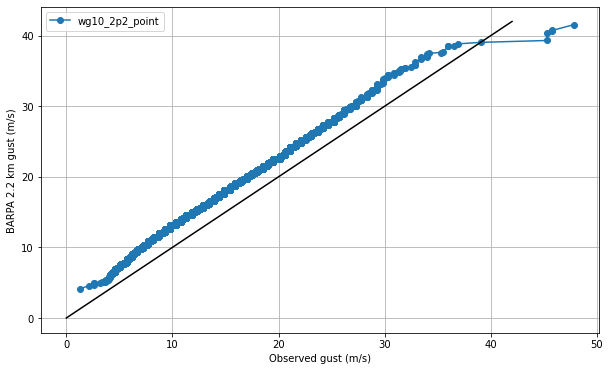

In [8]:
#Plot a QQ-plot by:
# -> For every observed gust (less than 60 m/s), calculate its quantile within the observed distribution
# -> For every modelled gust, calculate its quantile within the model distribution
# -> Because there are less model gusts, interpolate the model quantiles to the obs quantiles

gust = df[(np.in1d(df.month,[12,1,2])) & (pd.to_datetime(df["time"]) < dt.datetime(2015,12,1)) & (df.gust<=60)].gust.sort_values().reset_index()[["gust"]]
wg10_2p2_point = df[(np.in1d(df.month,[12,1,2])) & (pd.to_datetime(df["time"]) < dt.datetime(2015,12,1))].wg10_2p2_point.sort_values().dropna().reset_index()[["wg10_2p2_point"]]

gust["quantile"] = np.array(gust.index.values / gust.shape[0])
wg10_2p2_point["quantile"] = np.array(wg10_2p2_point.index.values / wg10_2p2_point.shape[0])
gust["wg10_2p2_point"] = np.interp(gust["quantile"],wg10_2p2_point["quantile"],wg10_2p2_point["wg10_2p2_point"])


plt.figure(figsize=[10,6])
ax=plt.gca()
gust.plot(x="gust",y="wg10_2p2_point",marker="o",ax=ax)
plt.plot([0,42],[0,42],color="k")

plt.xlabel("Observed gust (m/s)")
plt.ylabel("BARPA 2.2 km gust (m/s)")

ax.grid()


In [12]:
df["test"] = df["wg10_2p2_point"] * df["mucape*s06"]

for v in ["wg10_12km_point","wg10_barra_12km_point","wg10_2p2_point","ebwd","test"]:
    print(v)
    print("AUC =",metrics.roc_auc_score((df[(np.in1d(df.month,[12,1,2])) & (pd.to_datetime(df["time"]) < dt.datetime(2015,12,1))]["scw"] * 1).values,
                  (df[(np.in1d(df.month,[12,1,2])) & (pd.to_datetime(df["time"]) < dt.datetime(2015,12,1))][v]).values), "\n")

wg10_12km_point
AUC = 0.6531553706121265 

wg10_barra_12km_point
AUC = 0.671857321583986 

wg10_2p2_point
AUC = 0.8228223817812591 

ebwd
AUC = 0.8641735567159851 

test
AUC = 0.9054160924958903 



<AxesSubplot:xlabel='wg10_2p2_point', ylabel='gust'>

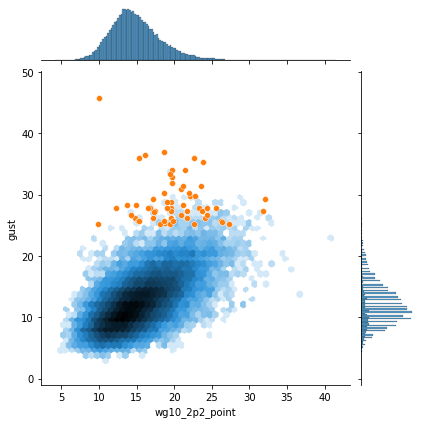

In [ ]:
sns.jointplot(data=df[(np.in1d(df.month,[12,1,2])) & (pd.to_datetime(df["time"]) < dt.datetime(2015,12,1))],
            x="wg10_2p2_point",y="gust",kind="hex",bins="log")
sns.scatterplot(data=df[(np.in1d(df.month,[12,1,2])) & (pd.to_datetime(df["time"]) < dt.datetime(2015,12,1))].query("scw==1"),
            x="wg10_2p2_point",y="gust",color="tab:orange")

Text(0.5, 0.98, 'ROC curves and AUC scores for DJF SCW events (N=60)')

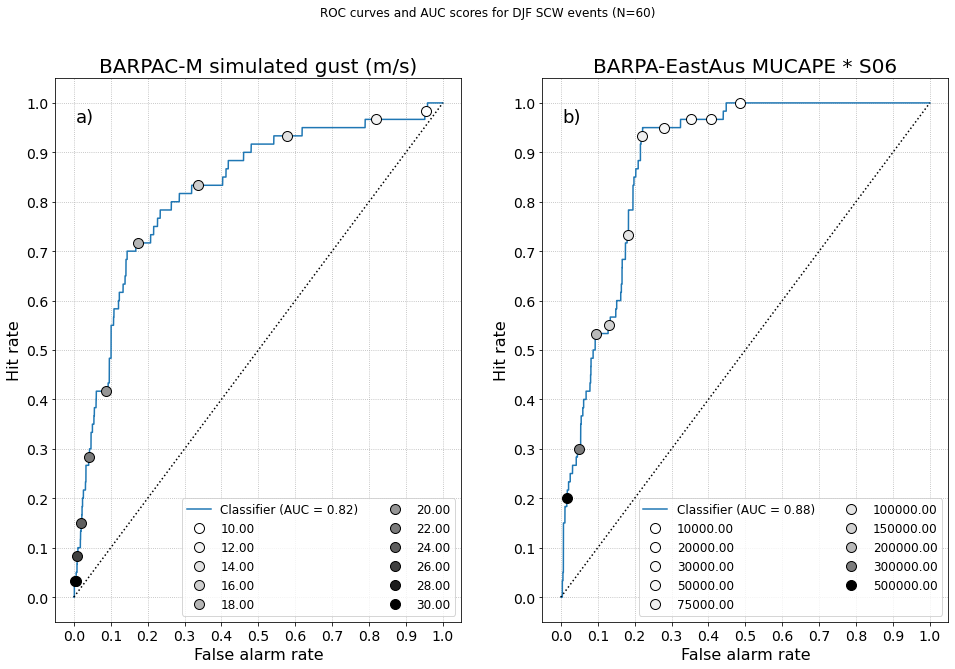

In [51]:
def interp_roc(x, fpr, tpr, thresholds):
    return np.interp(x, np.flip(thresholds), np.flip(fpr)), np.interp(x, np.flip(thresholds), np.flip(tpr))

def plot_roc(ax, v, thresh_list, df, cmap, letter, title):

    metrics.RocCurveDisplay.from_predictions(df["scw"],df[v],ax=ax)
    fpr, tpr, thresholds = metrics.roc_curve(df["scw"],df[v])
    #for t in [0.0,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1.0]:
    for t in thresh_list:
        x, y = interp_roc(t, fpr, tpr, thresholds)
        ax.plot(x, y, marker="o",label='%.2f' % (t), color=cmap((t-np.min(thresh_list))/(np.max(thresh_list)-np.min(thresh_list))), mec="k", ls="none", ms=10)
       
    plt.legend(fontsize=12,ncol=2,loc=4)
    ax.plot([0,1],[0,1],color="k",ls=":")
    ax.grid(ls=":")
    ax.set_ylabel("Hit rate",size=16)
    ax.set_xlabel("False alarm rate",size=16)
    ax.tick_params("both",labelsize=14)
    ax.set_xticks(np.arange(0,1.1,.1))
    ax.set_yticks(np.arange(0,1.1,.1)) 
    ax.text(0.05,0.92,letter+")",size=18,transform=ax.transAxes)
    ax.set_title(title,size=20)
    
plt.figure(figsize=[16,10])

plot_roc(plt.subplot(1,2,1), "wg10_2p2_point", np.arange(10,32,2), 
         df[(np.in1d(df.month,[12,1,2])) & (pd.to_datetime(df["time"]) < dt.datetime(2015,12,1))], plt.get_cmap("Greys"), "a", "BARPAC-M simulated gust (m/s)")

plot_roc(plt.subplot(1,2,2), "mucape*s06", np.array([10,20,30,50,75,100,150,200,300,500]) * 1000, 
         df[(np.in1d(df.month,[12,1,2])) & (pd.to_datetime(df["time"]) < dt.datetime(2015,12,1))], plt.get_cmap("Greys"), "b", "BARPA-EastAus MUCAPE * S06")

plt.suptitle("ROC curves and AUC scores for DJF SCW events (N=60)")